In [1]:
import loompy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
from matplotlib import gridspec

import rpy2.robjects as robj
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import DataFrame, FloatVector, IntVector, StrVector, ListVector, Matrix, BoolVector
from rpy2.rinterface import RNULLType
from collections import OrderedDict

plt.rcParams.update({'figure.max_open_warning': 150})

%matplotlib notebook

/home/lars/programs/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Data Import

In [2]:
file_name = '/home/lars/storage/Documents/Cortex_FISH/osmFISH_SScortex_mouse_all_cells.loom'

ds = loompy.connect(file_name)
ds

,,,CellID,778,1409,3642,1302,1285,769,1466,5870,1392,5682,...
,,,ClusterID,18,18,18,18,18,18,18,18,18,18,...
,,,ClusterName,Inhibitory CP,Inhibitory CP,Inhibitory CP,Inhibitory CP,Inhibitory CP,Inhibitory CP,Inhibitory CP,Inhibitory CP,Inhibitory CP,Inhibitory CP,...
,,,Region,Layer 6,Internal Capsule Caudoputamen,Layer 4,Internal Capsule Caudoputamen,Internal Capsule Caudoputamen,Layer 4,White matter,Layer 4,Internal Capsule Caudoputamen,Layer 2-3 medial,...
,,,Total_molecules,390,279,405,132,276,491,87,518,239,210,...
,,,Valid,1,1,1,1,1,1,1,1,1,1,...
,,,X,18171.230942376023,19838.08089469819,11247.433714967248,19253.231298951596,19612.52746706525,18374.295795684622,18132.019761954383,4197.789280405199,20452.07268496869,3757.866348635427,...
,,,Y,24590.795274569497,6456.144686569438,36626.892415142735,7389.731237290762,10793.160565894526,26286.856653908053,2115.0370273875524,39465.355902861425,6184.981168761355,46281.16716625502,...
,,,_tSNE_1,-58.13238525390625,-54.57238006591797,-61.572853088378906,-57.90510559082031,-59.13956832885742,-66.86224365234375,-54.061279296875,-59.923431396484375,-57.11332702636719,-64.76947021484375,...
,,,_tSNE_2,5.219181060791016,12.113470077514648,-1.1853644847869873,9.22524356842041,7.926783084869385,-1.7665001153945923,6.972393035888672,-3.7398080825805664,8.048858642578125,5.166342735290527,...
,,,size_pix,60911.0,31781.0,44143.0,18163.0,37353.0,41014.0,9660.0,42376.0,34809.0,23922.0,...


In [3]:
#Make Panda's Dataframe with count data
df_osmfish = pd.DataFrame(data=ds[:,:], columns=ds.ca['CellID'], index=ds.ra['Gene']).astype(int)

#Include cells: 
    #with more than 0 molecules
include_mol = ds.ca.Total_molecules >= 0
    #larger than 25 um2
include_size_min = ds.ca.size_um2 >= 5
    #smaller than 272 um2
include_size_max = ds.ca.size_um2 <= 275
    #Not in the double imaged region
include_position = ds.ca.X >= 0

include = np.logical_and(np.logical_and(include_mol,include_size_min), np.logical_and(include_size_max,include_position))

#include = np.logical_and(np.logical_and(ds.ca.Total_molecules > 20, ds.ca.size_pix > 2000), ds.ca.size_pix < 60000)
df_osmfish = df_osmfish.loc[:, include]    

print('Final shape is: {} genes and {} cells'.format(df_osmfish.shape[0], df_osmfish.shape[1]))

Final shape is: 33 genes and 5328 cells


In [4]:
# normalize data by total number of molecules per cell and per gene.
df_osmfish_totmol = df_osmfish.divide(df_osmfish.sum(axis=1), axis=0) * df_osmfish.shape[0] #Corrected for total molecules per gene
df_osmfish_totmol = df_osmfish_totmol.divide(df_osmfish_totmol.sum(axis=0), axis=1) * df_osmfish.shape[1] #Corrected for the total per cell
#Replace NA and Nan with zero:
df_osmfish_totmol = df_osmfish_totmol.fillna(0)

df_osmfish_totmol

,778,1409,3642,1302,1285,769,1466,5870,1392,5682,...,1252,1446,5730,6266,1188,1424,1024,1307,5665,5479
Gad2,268.472283,151.823164,791.823063,515.657661,446.830630,603.782295,587.654844,607.061070,730.374002,236.724105,...,161.861319,512.315783,353.574952,153.570578,0.000000,14.124486,101.390181,31.868808,53.728992,47.221784
Slc32a1,867.641535,680.638436,1126.745125,1083.895038,1172.596928,1380.607691,682.627488,764.572920,989.171163,1557.348791,...,558.184991,471.130854,0.000000,35.306270,0.000000,428.637742,0.000000,175.841298,148.229197,0.000000
Crhbp,0.000000,51.181667,224.786859,0.000000,0.000000,704.149719,0.000000,142.364242,0.000000,0.000000,...,54.565667,0.000000,0.000000,207.082978,0.000000,76.184923,36.458686,0.000000,0.000000,0.000000
Cnr1,131.845360,0.000000,20.466329,120.588967,53.521031,26.713008,151.891725,129.619381,130.430154,491.843816,...,99.361579,119.807453,289.398073,125.696205,0.000000,34.682313,82.986996,0.000000,395.790481,347.855633
Vip,67.710391,27.920341,49.049795,144.502324,96.201754,64.020645,182.012566,38.830878,195.368831,107.159773,...,476.261782,143.565832,173.393534,414.211465,0.000000,83.119957,159.109930,281.312955,158.092529,138.945678
Cpne5,546.752397,79.571659,34.947403,0.000000,0.000000,0.000000,129.681816,0.000000,0.000000,0.000000,...,0.000000,511.444848,0.000000,0.000000,0.000000,118.443987,0.000000,133.621451,225.278141,0.000000
Pthlh,0.000000,94.922900,83.379154,0.000000,109.021467,380.897724,0.000000,462.056983,0.000000,0.000000,...,303.596870,0.000000,0.000000,256.041116,0.000000,282.589223,67.617262,0.000000,0.000000,472.384162
Crh,113.210516,0.000000,184.523277,0.000000,80.423773,80.280996,0.000000,0.000000,97.995917,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,208.462535,648.445312,0.000000,198.245829,174.235944
Tbr1,168.528637,77.214096,54.259160,59.943482,124.155410,97.377498,125.839579,343.639488,0.000000,44.452779,...,41.159646,119.110000,287.713357,124.964470,380.434634,68.960824,154.007264,103.729992,87.441424,76.851246
Lamp5,25.721930,99.435215,0.000000,247.021965,105.067662,0.000000,25.928707,13.829189,133.590634,854.868480,...,33.923076,163.614042,395.214049,5.364249,32.661221,76.965866,5.666525,187.014813,517.986783,19.793589


In [5]:
def normalization(df):
    totmol = df.divide(df.sum(axis=1), axis=0) * df.shape[0] #Corrected for total molecules per gene
    totmol = totmol.divide(totmol.sum(axis=0), axis=1) * df.shape[1] #Corrected for the total per cell
    #Replace NA and Nan with zero:
    totmol = totmol.fillna(0)
    return totmol

In [6]:
#Load the cell coordinates into a Pandas Dataframe. Units are pixels
tSNE_data = np.stack((ds.ca.X, ds.ca.Y))
df_coordinates = pd.DataFrame(data = tSNE_data, index=['X', 'Y'], columns=ds.ca.CellID)

In [7]:
#Load the cell coordinates into a Pandas Dataframe. Units are pixels
coordinates = np.stack((ds.ca.X, ds.ca.Y))
df_coordinates = pd.DataFrame(data = coordinates, index=['X', 'Y'], columns=ds.ca.CellID)

In [160]:
import scipy.spatial

data = df_coordinates.loc[:,df_osmfish.columns].T

kdt = scipy.spatial.cKDTree(data)
k = 1 
dists, neighs = kdt.query(data, k+1)
avg_dists = np.mean(dists[:, 1:], axis=1)
avg_dist =np.mean(avg_dists)
avg_std = (np.std(avg_dists))

print('Average inter cell distance: {} std: {}'.format(avg_dist * 0.065, avg_std * 0.065))


Average inter cell distance: 10.003196765452383 std: 7.858814817592668


# Clustering

In [8]:
def heat_map(df, labels, sort=None, cluster_colors=None, cluster_number = False, save=False, name=''):
    """
    Plot heat_map of a dataframe.
    Input:
    `df`(pandas dataframe): Dataframe to plot. Cells as columns, genes as rows.
    `labels`(list/array): list of labels of the cells in the same order as the 
        df columns.
    `sort`(list): List of sorted cluster numbers. If None it will plot them in
        assending order
    `cluster_colors`(dict): Dictionary matching cluster numbers with colors
        in the hex fomat. Like '#ff0000' for red
    `cluster_number`(bool): Show cluster numbers in the top color bar. Usefull
        when manually sorting the clusters.
    `save`(bool): option to save the figure as png with 300dpi.
    `name`(str): Name to use when saving
    
    """
    #Find the name of the input df, for logging
    df_input_name =[x for x in globals() if globals()[x] is df][0]
    print('df used for plot: {}'.format(df_input_name))
    
    if sort == None:
        optimal_order = np.unique(labels)    
    else:
        optimal_order = sort
    print('Order of clusters: {}'.format(optimal_order))
    
    cl, lc = gen_labels(df, np.array(labels))[:2]
    
    #Sort the cells according to the optimal cluster order
    optimal_sort_cells = sum([lc[i] for i in optimal_order], [])
    
    #Create a list of optimal sorted cell labels
    optimal_sort_labels = [cl[i] for i in optimal_sort_cells]
    
    fig, axHM = plt.subplots(figsize=(9,5))
    
    df_full = df.copy()
    z = df_full.values
    z = z/np.percentile(z, 99, 1)[:,None]
    z = pd.DataFrame(z, index=df_full.index, columns=df_full.columns)
    z = z.loc[:,optimal_sort_cells].values
    
    im = axHM.pcolormesh(z, cmap='viridis', vmax=1)
    
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index, fontsize=8)
    plt.gca().invert_yaxis()
    plt.xlim(xmax=len(labels))

    divider = make_axes_locatable(axHM)
    axLabel = divider.append_axes("top", .3, pad=0, sharex=axHM)
  
    counter = Counter(labels)
    pos=0
    if cluster_colors == None:
        optimal_sort_labels = np.array(optimal_sort_labels)
        axLabel.pcolor(optimal_sort_labels[None,:]/max(optimal_sort_labels), cmap='jet')
        if cluster_number==True:
            for l in optimal_order:
                axLabel.text(pos + (counter[l]/2), 1.2, l, fontsize=8,
                         horizontalalignment='center', verticalalignment='center')
                pos += Counter(labels)[l]
        
    else:
        for l in optimal_order:
            #Use Bottom instead of y for older versions of matplotlib
            axLabel.barh(y = 0, left = pos, width = counter[l], color=cluster_colors[l],
                        linewidth=0.5, edgecolor=cluster_colors[l])
            if cluster_number==True:
                axLabel.text(pos + (counter[l]/2), 0, l, fontsize=8,
                         horizontalalignment='center', verticalalignment='center')
            pos += Counter(labels)[l]
    
    axLabel.set_xlim(xmax=len(labels))
    axLabel.axis('off')
    
    cax = fig.add_axes([.91, 0.13, 0.01, 0.22])
    colorbar = fig.colorbar(im, cax=cax, ticks=[0,1])
    colorbar.set_ticklabels(['0', 'max'])
    
    if save == True:
        plt.savefig('{}.png'.format(name), dpi=300)
 
    
def gen_labels(df, model):
    """
    Generate cell labels from model.
    Input:
    `df`: Panda's dataframe that has been used for the clustering. (used to get
    the names of colums and rows)
    `model`(obj OR array): Clustering object. OR numpy array with cell labels.
    Returns (in this order):
    `cell_labels` = Dictionary coupling cellID with cluster label
    `label_cells` = Dictionary coupling cluster labels with cellID
    `cellID` = List of cellID in same order as labels
    `labels` = List of cluster labels in same order as cells
    `labels_a` = Same as "labels" but in numpy array
    
    """
    if str(type(model)).startswith("<class 'sklearn.cluster"):
        cell_labels = dict(zip(df.columns, model.labels_))
        label_cells = {}
        for l in np.unique(model.labels_):
            label_cells[l] = []
        for i, label in enumerate(model.labels_):
            label_cells[label].append(df.columns[i])
        cellID = list(df.columns)
        labels = list(model.labels_)
        labels_a = model.labels_
    elif type(model) == np.ndarray:
        cell_labels = dict(zip(df.columns, model))
        label_cells = {}
        for l in np.unique(model):
            label_cells[l] = []
        for i, label in enumerate(model):
            label_cells[label].append(df.columns[i])
        cellID = list(df.columns)
        labels = list(model)
        labels_a = model
    else:
        print('Error wrong input type')
    
    return cell_labels, label_cells, cellID, labels, labels_a

def iterative_clustering(df, expression_threshold, alpha, min_clust_size, dataset_fraction = 0.1, 
                         allow_level_difference=False, max_cycles = 50, post_merge_bool=False, 
                         post_merge_cutoff = 0, linkage_method='single', 
                         linkage_metric='correlation', fcluster_criterion='distance',
                        verbose=True):
    """
    Automatic clustering by bifurcation. In each cycle the dataset(s) are split into two by 
    agglomerative clustering. Each daughter cluster is evaluated to see if it contains
    more complexity and should be split further or if it is a homogenous cluster. The 
    intermediate and final labels of each cell are added to the label matrix. Each row is
    the result of a clustering cycle where each of the individual labels are split and 
    evaluated. If a cluster is done the label is permanently added to the label matrix.
    When all clusters are done the clustering stops. 
    Optionally it is possible to merge clusters again after clustering. This functionality 
    is added because the agglomerative clustering somtimes makes splits based on a gene
    expression level difference (that can not be caught by the "allow_level_difference"
    parameter), which might not be desirable depending on the expriment/biology.
    Input:
    `df`(pandas dataframe): Dataframe to clusters. Cells as columns, genes as rows.
    `expression_threshold`(float): Value above which a gene is considered expressed. 
        Normalize the data such that the threshold makes sense for all genes.
    `alpha`(float): p-value cutoff for Mann-Whitney U test to decide if there is a 
        expression difference between two clusers. The function makes multiple 
        comparisons.
    `min_cluste_size`(int): Minimal number of cells per cluster.
    `dataset_fraction`(float 0-1): If a subcluster is larger than the dataset_fraction
        times the number of cells, it is classified as too large and will be further 
        clustered. 
    `allow_level_difference`(bool): Whether or not a cluster is allowed to split based
        on a significant level difference between the same enriched genes. (Does not
        catch all cases, see post_merge)
    `max_cycles`(int): Max number of cycles of clustering. Will print an statement if
        clustering is not yet done when the max number is reached.
    `post_merge_bool`(bool): After clustering, merge clusters that correlate with each 
        other. A linkage tree is calculated using the given 'linkage_method' and
        'linkage_metric'. Which clusters are merged is depending on the distance
        they have on this tree and is defined by the 'post_merge_cutoff'. The
        dendrogram will be plotted.
    `post_merge_cutoff`(float): Distance on the tree below which clusters should
        merge.   
    `linkage_method`(string): Scipy linkage methods. Default = 'single'
    `linkage_metric`(string): Scipy lingae metric. Default = 'correlation'
    `fcluster_criterion`(string): Scipy fcluster criterion. Default = 'distance'
    
    Returns:
    `label_matrix` (pandas datafame): Table of the cluster labels for each cell. Each
        row contains one iteration. Last row contains the final clusters. 
        Acces: label_matrix.iloc[-1]
    
    """
    #Verbose option
    verboseprint = print if verbose else lambda *a, **k: None

    def cluster_evaluation(df1, df2, expression_threshold, alpha, dataset_fraction, allow_level_difference=False):
        """
        Check if the clusters pass the criteria.
        Returns: 
        Evaluation, format: [x,y]
        x: 0=no enriched genes, 1=same enriched genes, 2=different enriched genes
            3=one of the sub clusters is too large
        y: 0=no differentially expressed genes, 1=same genes differentially expressed
            (level difference), 2=genes differentially expressed

        """
        evaluation = [0,0]

        enriched_df1 = []
        for g in df1.index:
            if df1.loc[g].mean() > expression_threshold and scipy.stats.mannwhitneyu(df1.loc[g], df2.loc[g], alternative='two-sided')[1] < alpha:
                enriched_df1.append(g)
                
        enriched_df2 = []
        for g in df2.index:
            if df2.loc[g].mean() > expression_threshold and scipy.stats.mannwhitneyu(df1.loc[g], df2.loc[g], alternative='two-sided')[1] < alpha:
                enriched_df2.append(g)
                
        if df1.shape[1] > (dataset_fraction * df.shape[1]) or df2.shape[1] > (dataset_fraction * df.shape[1]):
            evaluation[0] = 3
        #No enriched genes in both groups
        elif enriched_df1 == [] and enriched_df2 == []: 
            evaluation = [0,0]
        #Same enriched genes for both groups, level difference
        elif enriched_df1 == enriched_df2: 
            if allow_level_difference == True:
                evaluation = [1,1]
            else:
                evaluation = [0,0]
        #At least one gene differentialy enriched
        elif enriched_df1 != enriched_df2: 
            evaluation = [2,2]

        return evaluation
    
    def re_cluster(dfs = []):
        """
        Evaluate a list of clusters (dataframes) by splitting them again and 
        evaluating the daughter clusters.
        Input:
        `dfs`(list): List of Pandas dataframes containing one cluster.

        """
        re_evaluation = []
        for d in dfs:
            split = AgglomerativeClustering(n_clusters=2).fit(d.T)
            split_labels = split.labels_ 
            df_daughter_1 = d.loc[:,split_labels == np.unique(split_labels)[0]]
            df_daughter_2 = d.loc[:,split_labels == np.unique(split_labels)[1]]
            re_evaluation.append(cluster_evaluation(df_daughter_1, df_daughter_2, expression_threshold, 
                                                    alpha, dataset_fraction,
                                                    allow_level_difference=allow_level_difference))
        return(re_evaluation)  
    
            
    def mean_expression(df, labels):
        """
        Make dataframe with mean expression per label.

        """
        #Make df with count averages per cluster
        df_count_average = pd.DataFrame(index=df.index, columns=np.sort(np.unique(labels))) #np.unique(labels_a))
        for l in np.unique(labels):
            filt = labels == l
            mean = np.array(df.loc[:,filt].T.mean())
            if np.isnan(np.sum(mean)) == False: #In case some clusters do not have cells
                df_count_average[l] = mean
        return df_count_average
    
    def post_merge(df, labels, post_merge_cutoff, linkage_method=linkage_method, linkage_metric=linkage_metric, fcluster_criterion=fcluster_criterion):
        """
        Merge clusters based on likage and a cutoff. The mean expression levels of 
        the clusters are linked and them merged based on the cutoff provided.
        Input:
        `df`(Pandas dataframe): df with expression matrix. row-genes, col-cells.
        `labels`(list/array): Labels of the cells.
        `post_merge_cutoff`(float): Merge clusters that have a distance from each 
            other below the cutoff.
        `linkage_method`(string): Scipy linkage methods. Default = 'single'
        `linkage_metric`(string): Scipy lingae metric. Default = 'correlation'
        `fcluster_criterion`(string): Scipy fcluster criterion. Default = 'distance'

        Returns:
        `new_labels`(list): List of new cell labels after merging. 
        Additionally it plots the dendrogram showing which clusters are merged.

        """
        #merge the labels based on parameters
        df_mean = mean_expression(df, labels)
        Z = scipy.cluster.hierarchy.linkage(df_mean.T, method=linkage_method, metric=linkage_metric)
        merged_labels_short = scipy.cluster.hierarchy.fcluster(Z, post_merge_cutoff, criterion=fcluster_criterion)

        #Update labels  
        label_conversion = dict(zip(df_mean.columns, merged_labels_short))
        label_conversion_r = dict(zip(merged_labels_short, df_mean.columns))
        new_labels = [label_conversion[i] for i in labels] 

        #Plot the dendrogram to visualize the merging
        if verbose == True:
            fig, ax = plt.subplots()
            scipy.cluster.hierarchy.dendrogram(Z, labels=df_mean.columns ,color_threshold=post_merge_cutoff)
            ax.hlines(post_merge_cutoff, 0, ax.get_xlim()[1])
            ax.set_title('Merged clusters')
            ax.set_ylabel(linkage_metric)
            ax.set_xlabel('pre-merge cluster labels')

        verboseprint('Merged clusters. Started with {} clusters, merging results to {} clusters.'.format(
            len(np.unique(labels)), len(np.unique(merged_labels_short))))
        
        for k in label_conversion.keys():
            verboseprint('Old label:{:>3} is converted to: {}'.format(k, label_conversion[k]))

        return new_labels 

    #=========================================================================
    finished_clusters = []
    label_ofset = 0
    finished = False

    #Make matrix for labels. First row all zeros
    label_matrix = pd.DataFrame(data= np.zeros((1, df.shape[1])), index = ['Level_0'], columns=df.columns, dtype='Int64')

    for cycle, x in enumerate(range(max_cycles)):

        previous_level = 'Level_{}'.format(cycle)
        current_level = 'Level_{}'.format(cycle + 1)

        if list(set(label_matrix.loc[previous_level]) - set(finished_clusters)) == []:
            verboseprint('\nNo difference between the last two label levels. Clustering completed.')
            finished = True
            break

        #Add row and copy labels
        label_matrix.loc[current_level] = label_matrix.loc[previous_level]

        #Loop through all labels that are not in finished_clusters
        for old_label in [i for i in np.unique(label_matrix.loc[current_level]) if i not in finished_clusters]:
            label_ofset += 2
            verboseprint('Clustering: {}, label: {}'.format(current_level, old_label))

            #Create dataframe to split
            filt = label_matrix.loc[current_level] == old_label
            df_to_split = df.loc[:,filt]

            #Cluster dataframe into two clusters
            split = AgglomerativeClustering(n_clusters=2).fit(df_to_split.T)
            split_labels = split.labels_ + label_ofset #Labels are 0 and 1, shift them with the clustering step
            unique_split_labels = np.unique(split_labels)

            #Check if all the clusters are larger than the min_clust_size
            if all(i > min_clust_size for i in list(Counter(split_labels).values())):

                #Make df1 & df2
                df1 = df_to_split.loc[:,split_labels == unique_split_labels[0]]
                df2 = df_to_split.loc[:,split_labels == unique_split_labels[1]]

                #Evaluate split
                evaluation = cluster_evaluation(df1, df2, expression_threshold, alpha, dataset_fraction)

                verboseprint('    Daughter clusters labels: {}, evaluation of split: {}'.format(unique_split_labels, evaluation))
                #List of the labels that are valid clusters (or will be in the next cycle)
                valid_labels = []

                #_____________________________________________________________________
                if evaluation[0] == 3:
                    verboseprint('    At least one of the daughter clusters is too large')
                    threshold = dataset_fraction * df.shape[1]
                    if df1.shape[1] > threshold and df2.shape[1] > threshold:
                        valid_labels.extend(unique_split_labels)
                    elif df1.shape[1] > threshold:
                        valid_labels.append(unique_split_labels[0])
                        re_evaluation = re_cluster([df2])
                        if re_evaluation[0][1] == 0:
                            finished_clusters.append(unique_split_labels[1])
                            valid_labels.append(unique_split_labels[1])
                        else: #Difference in daughters, continue clustering
                            valid_labels.append(unique_split_labels[1])
                    elif df2.shape[1] > threshold:
                        valid_labels.append(unique_split_labels[1])
                        re_evaluation = re_cluster([df1])
                        if re_evaluation[0][1] == 0:
                            finished_clusters.append(unique_split_labels[0])
                            valid_labels.append(unique_split_labels[0])
                        else: #Difference in daughters, continue clustering
                            valid_labels.append(unique_split_labels[0])


                #No enriched genes, NO expression difference
                elif evaluation[0] == 0:
                    verboseprint('    No enriched genes, No expression difference')
                    re_evaluation = re_cluster([df1, df2])
                    #No valid daughter clusters in the next cycle
                    if re_evaluation[0][1] == 0 and re_evaluation[1][1] == 0:
                        finished_clusters.append(old_label)
                        verboseprint('    Encountered a cluster without enriched genes: {}{}'.format(current_level, old_label))
                    #Valid daughter clusters in the next cycle
                    else:
                        valid_labels.extend(unique_split_labels)

                #Different genes enriched, expression difference
                elif evaluation[0] == 2 and evaluation[1] == 2:
                    verboseprint('    Different enriched genes, expression difference')
                    re_evaluation = re_cluster([df1, df2])
                    #First cluster
                    if re_evaluation[0][1] == 0: #no difference in daughter clusters, current cluster finished
                        finished_clusters.append(unique_split_labels[0])
                        valid_labels.append(unique_split_labels[0])
                    else: #Difference in daughters, continue clustering
                        valid_labels.append(unique_split_labels[0])
                    #Second cluster
                    if re_evaluation[1][1] == 0: #no difference in daughter clusters, current cluster finished
                        finished_clusters.append(unique_split_labels[1])
                        valid_labels.append(unique_split_labels[1])
                    else: #Difference in daughters, continue clustering
                        valid_labels.append(unique_split_labels[1])    


                #Different genes enriched, NO expression difference
                elif evaluation[0] == 2 and evaluation[1] == 0:
                    verboseprint('    Encounterd a difference but no significant difference {} {}-->{}'.format(current_level, old_label, unique_split_labels))
                    re_evaluation = re_cluster([df1, df2])
                    if re_evaluation[0][1] == 0 and re_evaluation[1][1] == 0: #No valid daughter clusters
                        finished_clusters.append(old_label)
                    else:
                        valid_labels.extend(unique_split_labels)

                #Same or more enriched, expression level difference
                elif evaluation[0] > 0 and evaluation[1] == 1:
                    verboseprint('    Encountered a split with similar expressed genes')
                    if allow_level_difference == True:
                        valid_labels.extend(unique_split_labels)
                        finished_clusters.extend(unique_split_labels)
                    else:
                        finished_clusters.append(old_label)


                #Same enriched, NO expression difference
                elif evaluation[0] == 1 and evaluation[1] == 0:
                    verboseprint('    Same genes enriched but no expression idfference')
                    finished_clusters.append(old_label) #Not a valid split, current cluster finished  

                else:
                    verboseprint('ERROR, Split evaluation did not fit the criteria: {} in: {} {}'.format(evaluation, current_level, old_label))

                #_____________________________________________________________________

            else:
                finished_clusters.append(old_label)

            #Add labels to matrix
            final_split_labels = [old_label if i not in valid_labels else i for i in split_labels]
            for c, i in enumerate(filt):
                if i == True:
                    count_true = Counter(filt[:c])[True] #Count how many Trues already have been passed
                    label_matrix.loc[current_level][c] = final_split_labels[count_true] #Add the new labels to the label matrix
            verboseprint('Finished Clusters:  {}\n'.format(finished_clusters))
    
    if finished == False:
        print('Max number of cycles reached. Possibly there is more structure with more rounds of clustering.')
    print('\nClustering finished. Result {} clusters with labels: {}\n'.format(len(np.unique(label_matrix.iloc[-1])), np.unique(label_matrix.iloc[-1])))
    
    if post_merge_bool == True:
        label_matrix.loc['Post_merge'] = post_merge(df, label_matrix.iloc[-1], post_merge_cutoff, 
                                                    linkage_method=linkage_method, linkage_metric=linkage_metric, 
                                                    fcluster_criterion=fcluster_criterion)
        print('\nMerging finished. Result {} clusters with labels: {}\n'.format(len(np.unique(label_matrix.iloc[-1])), 
                                                                                np.unique(label_matrix.iloc[-1])))
    
    return label_matrix

Clustering: Level_1, label: 0
    Daughter clusters labels: [2 3], evaluation of split: [3, 0]
    At least one of the daughter clusters is too large
Finished Clusters:  []

Clustering: Level_2, label: 2
    Daughter clusters labels: [4 5], evaluation of split: [3, 0]
    At least one of the daughter clusters is too large
Finished Clusters:  []

Clustering: Level_2, label: 3
    Daughter clusters labels: [6 7], evaluation of split: [3, 0]
    At least one of the daughter clusters is too large
Finished Clusters:  [7]

Clustering: Level_3, label: 4
    Daughter clusters labels: [8 9], evaluation of split: [3, 0]
    At least one of the daughter clusters is too large
Finished Clusters:  [7]

Clustering: Level_3, label: 5
    Daughter clusters labels: [10 11], evaluation of split: [3, 0]
    At least one of the daughter clusters is too large
Finished Clusters:  [7, 11]

Clustering: Level_3, label: 6
    Daughter clusters labels: [12 13], evaluation of split: [3, 0]
    At least one of the 

Finished Clusters:  [7, 11, 13, 15, 17, 10, 25, 26, 27, 21, 33, 35, 37, 40, 43, 49, 51, 42, 55, 56, 57, 58, 59, 47, 63, 64, 65, 66, 68, 69, 71]

Clustering: Level_13, label: 72
    Daughter clusters labels: [74 75], evaluation of split: [3, 0]
    At least one of the daughter clusters is too large
Finished Clusters:  [7, 11, 13, 15, 17, 10, 25, 26, 27, 21, 33, 35, 37, 40, 43, 49, 51, 42, 55, 56, 57, 58, 59, 47, 63, 64, 65, 66, 68, 69, 71, 75]

Clustering: Level_13, label: 73
    Daughter clusters labels: [76 77], evaluation of split: [2, 2]
    Different enriched genes, expression difference
Finished Clusters:  [7, 11, 13, 15, 17, 10, 25, 26, 27, 21, 33, 35, 37, 40, 43, 49, 51, 42, 55, 56, 57, 58, 59, 47, 63, 64, 65, 66, 68, 69, 71, 75, 76, 77]

Clustering: Level_14, label: 74
    Daughter clusters labels: [78 79], evaluation of split: [3, 0]
    At least one of the daughter clusters is too large
Finished Clusters:  [7, 11, 13, 15, 17, 10, 25, 26, 27, 21, 33, 35, 37, 40, 43, 49, 51, 42

<IPython.core.display.Javascript object>


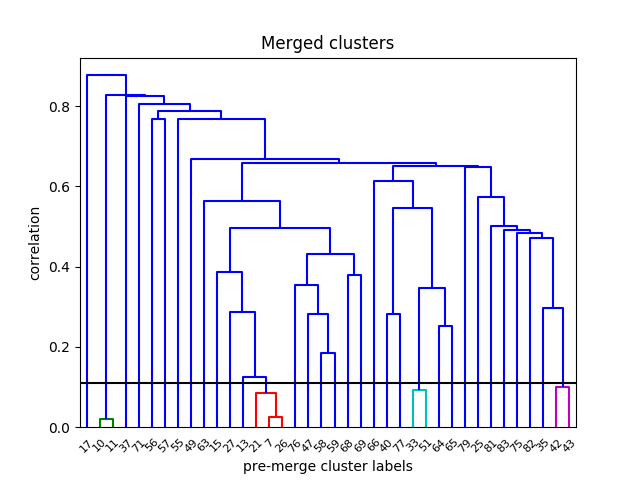

Merged clusters. Started with 38 clusters, merging results to 33 clusters.
Old label:  7 is converted to: 4
Old label: 10 is converted to: 1
Old label: 11 is converted to: 1
Old label: 13 is converted to: 5
Old label: 15 is converted to: 7
Old label: 17 is converted to: 33
Old label: 21 is converted to: 4
Old label: 25 is converted to: 27
Old label: 26 is converted to: 4
Old label: 27 is converted to: 6
Old label: 33 is converted to: 17
Old label: 35 is converted to: 22
Old label: 37 is converted to: 32
Old label: 40 is converted to: 15
Old label: 42 is converted to: 21
Old label: 43 is converted to: 21
Old label: 47 is converted to: 10
Old label: 49 is converted to: 29
Old label: 51 is converted to: 17
Old label: 55 is converted to: 30
Old label: 56 is converted to: 2
Old label: 57 is converted to: 3
Old label: 58 is converted to: 8
Old label: 59 is converted to: 9
Old label: 63 is converted to: 14
Old label: 64 is converted to: 18
Old label: 65 is converted to: 19
Old label: 66 is co

In [9]:
osmFISH_clust = iterative_clustering(df_osmfish_totmol, 
                     expression_threshold = 550,
                     alpha = 0.1e-20,
                     min_clust_size = 15, 
                     dataset_fraction = 0.05,
                     allow_level_difference=False, 
                     max_cycles = 50,
                     post_merge_bool = True,
                     post_merge_cutoff = 0.11,
                     verbose=True)

In [10]:
def clust_res(df, model):
    """
    Generate cell labels from model.
    Input:
    `df`: Panda's dataframe that has been used for the clustering. (used to get
    the names of colums and rows)
    `model`(obj OR array): Clustering object. OR numpy array with cell labels
        OR pandas dataframe with clustering results and final results in last
        row.
    Returns (in this order):
    `cell_labels` = Dictionary coupling cellID with cluster label
    `label_cells` = Dictionary coupling cluster labels with cellID
    `cellID` = List of cellID in same order as labels
    `labels` = List of cluster labels in same order as cells
    `labels_a` = Same as "labels" but in numpy array
    
    """
    if str(type(model)).startswith("<class 'sklearn.cluster"):
        cell_labels = dict(zip(df.columns, model.labels_))
        label_cells = {}
        for l in np.unique(model.labels_):
            label_cells[l] = []
        for i, label in enumerate(model.labels_):
            label_cells[label].append(df.columns[i])
        cellID = list(df.columns)
        labels = list(model.labels_)
        labels_a = model.labels_
    elif type(model) == np.ndarray:
        cell_labels = dict(zip(df.columns, model))
        label_cells = {}
        for l in np.unique(model):
            label_cells[l] = []
        for i, label in enumerate(model):
            label_cells[label].append(df.columns[i])
        cellID = list(df.columns)
        labels = list(model)
        labels_a = model
    elif type(model) == pd.core.frame.DataFrame:
        model = np.array(model.iloc[-1])
        cell_labels = dict(zip(df.columns, model))
        label_cells = {}
        for l in np.unique(model):
            label_cells[l] = []
        for i, label in enumerate(model):
            label_cells[label].append(df.columns[i])
        cellID = list(df.columns)
        labels = list(model)
        labels_a = model
    else:
        print('Error wrong input type')
        
    results = {
        'cell_labels': cell_labels,
        'label_calls': label_cells,
        'cellID': cellID,
        'labels': labels,
        'labels_a': labels_a}    
    
    
    return results

In [11]:
def clustering(df):
    clust = iterative_clustering(df, 
                     expression_threshold = 550,
                     alpha = 0.1e-20,
                     min_clust_size = 15, 
                     dataset_fraction = 0.05,
                     allow_level_difference=False, 
                     max_cycles = 50,
                     post_merge_bool = True,
                     post_merge_cutoff = 0.11,
                     verbose=False)
    
    labels = clust_res(df, clust)['labels_a']
    
    return labels

In [12]:
osmFISH_results = clust_res(df_osmfish_totmol, osmFISH_clust)

# ORIGINAL LABELS ############################################################
original_labels = osmFISH_results['labels_a']

df used for plot: df_osmfish
Order of clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]


<IPython.core.display.Javascript object>


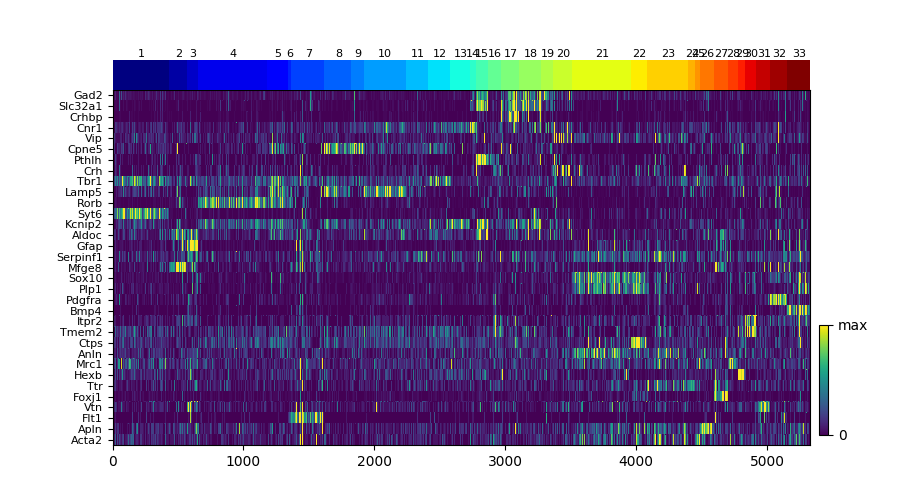

In [13]:
heat_map(df_osmfish, original_labels, cluster_number=True)

df used for plot: _
Order of clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]


<IPython.core.display.Javascript object>


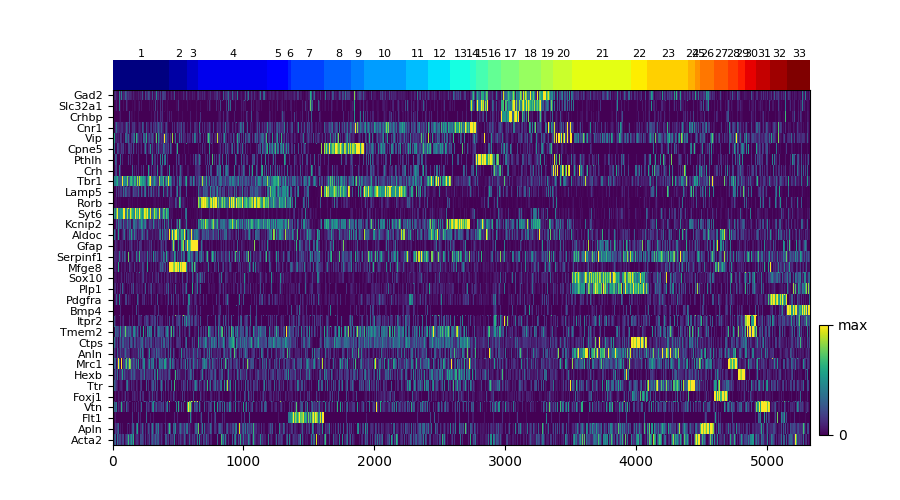

In [14]:
heat_map(df_osmfish_totmol, original_labels, cluster_number=True)

In [15]:
positive_clusters = {
'Gad2': [14,15,17,18,19,20],
'Slc32a1': [15,17,18,19,20],
'Crhbp': [17],
'Cnr1': [13,14],
'Vip': [20],
'Cpne5': [8,9,5],
'Pthlh': [15,16],
'Crh': [20],
'Tbr1': [1,2,3,4,5,6,7,8,9,10,11,12],
'Lamp5': [5,8,10],
'Rorb': [4,5],
'Syt6': [1],
'Kcnip2': [4,5,8,9,13],
'Aldoc': [2,3],
'Gfap': [3],
'Serpinf1': [11],
'Mfge8': [2],
'Sox10': [21,22,30,32,33],
'Plp1': [21,22,30,33],
'Pdgfra': [32],
'Bmp4': [33],
'Itpr2': [30],
'Tmem2': [30],
'Ctps': [22],
'Anln': [21],
'Mrc1': [28],
'Hexb': [29],
'Ttr': [24],
'Foxj1': [27,22],
'Vtn': [31],
'Flt1': [6,7],
'Apln': [26],
'Acta2': [25],
    
}

In [ ]:
for i in df_osmfish.index:
    print("'{}': [],".format(i))

# Cluster Compare

In [ ]:
from sklearn.metrics import adjusted_rand_score

In [ ]:
#o_lab_dict = dict(zip(ds.ca.CellID, ds.ca.ClusterID))
#original_labels = [o_lab_dict[i] for i in df_osmfish_totmol.columns]

In [ ]:
#adjusted_rand_score(osmFISH_results['labels_a'], original_labels)

In [ ]:
def cluster_compare(labels_A, labels_B):
    return adjusted_rand_score(labels_A, labels_B)

cluster_compare(original_labels, original_labels)

# Negative Binomial fit

In [ ]:
def recurList(data):
    '''Important utility that transforms a list object vector return from R to a python dictionary
    '''
    #define the kind of vector 
    # it is not using pandas for dataframes right now but it could be implemented if needed
    rDictTypes = [DataFrame,ListVector]
    rArrayTypes = [FloatVector,IntVector,Matrix,BoolVector,RNULLType]
    rListTypes=[StrVector]

    if type(data) in rDictTypes:
        return OrderedDict(zip(data.names, [recurList(elt) for elt in data]))
    elif type(data) in rListTypes:
        return [recurList(elt) for elt in data] #Recoursive call
    elif type(data) in rArrayTypes:
        return np.array(data)
    else:
        if hasattr(data, "rclass"): # An unsupported r class
            raise KeyError('Could not proceed, type {} is not defined'.format(type(data)))
        else:
            return data # We reached the end of recursion
        

def fitdist(data, distr="nbinom", method="mle"):
    '''
    Input
    -----
    data - numpy 1d array
        A numeric vector.

    distr - string
        A character string "name" naming a distribution:
        "norm", "lnorm", "pois", "exp", "gamma", "nbinom", "geom", "beta", "unif" and "logis"

    method - sting 
        A character string coding for the fitting method: 
        "mle" for maximum likeli-hood estimation
        "mme" for moment matching estimation
        "qme" for quantile matching estimation
        "mge" for maximum goodness-of-fit estimation

    (start - NOT IMPLEMENTED
        A named list giving the initial values of parameters of the named distribution)

    
    Returns
    -------
    estimate - 1d array
        the parameter estimates.
    method - string
        the character string coding for the fitting method
    sd - 1d array
        the estimated standard errors, NA if numerically not computable or NULL if not available.
    cor - 1d array
        the estimated correlation matrix, NA if numerically not computable or NULL if not available.
    vcov - 1d array
        the estimated variance-covariance matrix, NULL if not available. loglik the log-likelihood.
    aic - 1d array
        the Akaike information criterion.
    bic - 1d array
        the the so-called BIC or SBC (Schwarz Bayesian criterion). n the length of the data set.
    data - 1d array
        the data set.
    distname - str
        the name of the distribution.
    

    '''
    data = FloatVector(data)
    fitdistrplus = importr('fitdistrplus')
    res = fitdistrplus.fitdist(data= data, distr=distr, method=method, keepdata=False)
    return recurList(res)

def nbinom_rvs(nsamples, size, mu):
    rnbinom = robj.r('rnbinom')
    return np.array( rnbinom(n=nsamples,size=size,mu=mu) )

def nbinom_pdf(x, size, mu):
    dnbinom = robj.r('dnbinom')
    if np.isscalar(x):
        return np.array( dnbinom(x=x,size=size,mu=mu) )
    else:
        return np.array( dnbinom(x=FloatVector(x),size=size,mu=mu) )

def nbinom_rvs_fromfit(nsamples, fit_dict):
    rnbinom = robj.r('rnbinom')
    return np.array( rnbinom(n=nsamples,size=fit_dict['estimate'][0],mu=fit_dict['estimate'][1]) )

def nbinom_pdf_fromfit(x, fit_dict):
    dnbinom = robj.r('dnbinom')
    if np.isscalar(x):
        return np.array( dnbinom(x=x,size=fit_dict['estimate'][0],mu=fit_dict['estimate'][1]) )
    else:
        return np.array( dnbinom(x=FloatVector(x),size=fit_dict['estimate'][0],mu=fit_dict['estimate'][1]) )

def principal_curve(X, pca=True):
    """
    input : numpy.array
    returns:
    Result::Object
        Methods:
        projections - the matrix of the projectiond
        ixsort - the order ot the points (as in argsort)
        arclength - the lenght of the arc from the beginning to the point
    """
    # convert array to R matrix
    xr = array_to_rmatrix(X)
    
    if pca:
        #perform pca
        t = robj.r.prcomp(xr)
        #determine dimensionality reduction
        usedcomp = max( sum( np.array(t[t.names.index('sdev')]) > 1.1) , 4)
        usedcomp = min([usedcomp, sum( np.array(t[t.names.index('sdev')]) > 0.25), X.shape[0]])
        Xpc = np.array(t[t.names.index('x')])[:,:usedcomp]
        # convert array to R matrix
        xr = array_to_rmatrix(Xpc)

    #import the correct namespace
    princurve = importr("princurve")
    
    #call the function
    fit1 = princurve.principal_curve(xr)
    
    #extract the outputs
    class Results:
        pass
    results = Results()
    results.projections = np.array( fit1[0] )
    results.ixsort = np.array( fit1[1] ) - 1 # R is 1 indexed
    results.arclength = np.array( fit1[2] )
    results.dist = np.array( fit1[3] )
    
    if pca:
        results.PCs = np.array(xr) #only the used components
        
    return results

def array_to_rmatrix(X):
    nr, nc = X.shape
    xvec = robj.FloatVector(X.transpose().reshape((X.size)))
    xr = robj.r.matrix(xvec, nrow=nr, ncol=nc)
    return xr

In [ ]:
n = [1,2,3]

r = {k : [] for k in n}

for f in n:
    for i in range(5):
        r[f].append(f)

r

In [ ]:
#Filter out bad clusters
first = original_labels != 11
second = original_labels != 23
mask = np.logical_and(first, second)

In [ ]:
Counter(mask)
original_labels[mask].shape

In [ ]:
a = np.array([1,1,1,2,2,3,3,4,4,5])
bad = [2,3]

two = a != 2
three = a != 5

np.logical_and(two, three)

In [ ]:
#Filter out bad clusters
first = original_labels != 11
second = original_labels != 23
mask = np.logical_and(first, second)

In [ ]:
# fit distribution on all genes
fit = {gene: fitdist(df_osmfish.loc[gene]).get('estimate') for gene in df_osmfish.index}

#Filter out bad clusters
first = original_labels != 11
second = original_labels != 23
mask = np.logical_and(first, second)

def noise_eval(df, noise_fraction, nbinom_fit, original_labels, repeats=1):
    """
    Evaluate the effect of noise on the clustering
    
    """
    result = {k : [] for k in noise_fraction}
    result_labels = {k : [] for k in noise_fraction}
    
    print(noise_fraction)
    for f in noise_fraction:
        for i in range(repeats):
            print(f, i)
            copy = df.copy()

            #Add noise
            for gene in copy.index:
                noise = nbinom_rvs(df_osmfish.shape[1], nbinom_fit[gene][0], nbinom_fit[gene][1] * f)
                copy.loc[gene] += noise

            #Nomalize
            copy_n = normalization(copy)      

            #Cluster
            new_labels = clustering(copy_n)

            #Evaluate
            result[f].append(cluster_compare(original_labels[mask], new_labels[mask]))
            
            result_labels[f].append(new_labels)
        
    return result, result_labels

    
    

results, result_labels = noise_eval(df_osmfish, np.logspace(-4, 0, 15),
                                    fit, original_labels, repeats=10)
        

In [ ]:

#pickle.dump(results, open('noise_addition_rand_scores_clean.p', 'wb'))
#pickle.dump(result_labels, open('noise_addition_rand_scores_clean_labels.p', 'wb'))


In [16]:
results = pickle.load(open("noise_addition_rand_scores_clean.p", 'rb'))
result_labels = pickle.load(open("noise_addition_rand_scores_clean_labels.p", 'rb'))

<IPython.core.display.Javascript object>


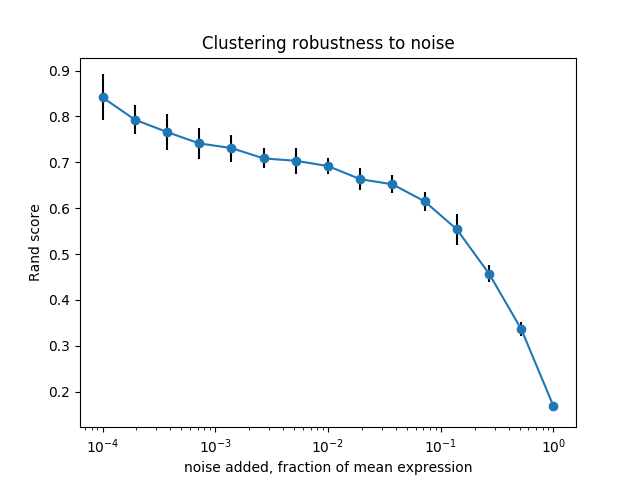

In [17]:
plt.figure()

x = results.keys()
y = [np.mean(results[i]) for i in x]
yerr = [np.std(results[i]) for i in x]

plt.errorbar(x, y, yerr=yerr, fmt='-o', ecolor='k')
plt.ylabel('Rand score')
plt.xlabel('noise added, fraction of mean expression')
plt.title('Clustering robustness to noise')
plt.xscale('log')

#plt.savefig('Rand_score_noise.png')

In [ ]:
# fit distribution on all genes
fit = {gene: fitdist(df_osmfish.loc[gene]).get('estimate') for gene in df_osmfish.index}

#Filter out bad clusters
first = original_labels != 11
second = original_labels != 23
mask = np.logical_and(first, second)

def noise_eval(df, noise_fraction, nbinom_fit, original_labels, repeats=1):
    """
    Evaluate the effect of noise on the clustering
    
    """
    result = {k : [] for k in noise_fraction}
    result_labels = {k : [] for k in noise_fraction}
    
    print(noise_fraction)
    for f in noise_fraction:
        for i in range(repeats):
            print(f, i)
            d1 = df.copy()
            d1 = df.copy()

            #Add noise
            for gene in d1.index:
                noise = nbinom_rvs(df_osmfish.shape[1], nbinom_fit[gene][0], nbinom_fit[gene][1] * f)
                copy.loc[gene] += noise

            #Nomalize
            copy_n = normalization(copy)      

            #Cluster
            new_labels = clustering(copy_n)

            #Evaluate
            result[f].append(cluster_compare(original_labels[mask], new_labels[mask]))
            
            result_labels[f].append(new_labels)
        
    return result, result_labels

    
    

results, result_labels = noise_eval(df_osmfish, np.logspace(-4, 0, 15),
                                    fit, original_labels, repeats=10)

### Estimate noise

In [ ]:
positive_clusters = {
'Gad2': [14,15,17,18,19,20],
'Slc32a1': [15,17,18,19,20],
'Crhbp': [17],
'Cnr1': [13,14],
'Vip': [20],
'Cpne5': [8,9,5],
'Pthlh': [15,16],
'Crh': [20],
'Tbr1': [1,2,3,4,5,6,7,8,9,10,11,12],
'Lamp5': [5,8,10],
'Rorb': [4,5],
'Syt6': [1],
'Kcnip2': [4,5,8,9,13],
'Aldoc': [2,3],
'Gfap': [3],
'Serpinf1': [11],
'Mfge8': [2],
'Sox10': [21,22,30,32,33],
'Plp1': [21,22,30,33],
'Pdgfra': [32],
'Bmp4': [33],
'Itpr2': [30],
'Tmem2': [30],
'Ctps': [22],
'Anln': [21],
'Mrc1': [28],
'Hexb': [29],
'Ttr': [24],
'Foxj1': [27,22],
'Vtn': [31],
'Flt1': [6,7],
'Apln': [26],
'Acta2': [25],   
}

In [18]:
def combine_bool_filters(labels, valid, mirror=False):
    
    #make an array from valid
    if type(valid) == list:
        valid = np.array(valid)
    
    #Make the first filter
    filt = labels == valid[0]
    
    #Add filters for other labels
    for i in valid[1:]:
        filt_add = labels == i
        filt = np.logical_or(filt, filt_add)
    
    #Flip the filter if mirror == True
    if mirror == True:
        filt = filt == False
    
    return filt

<IPython.core.display.Javascript object>


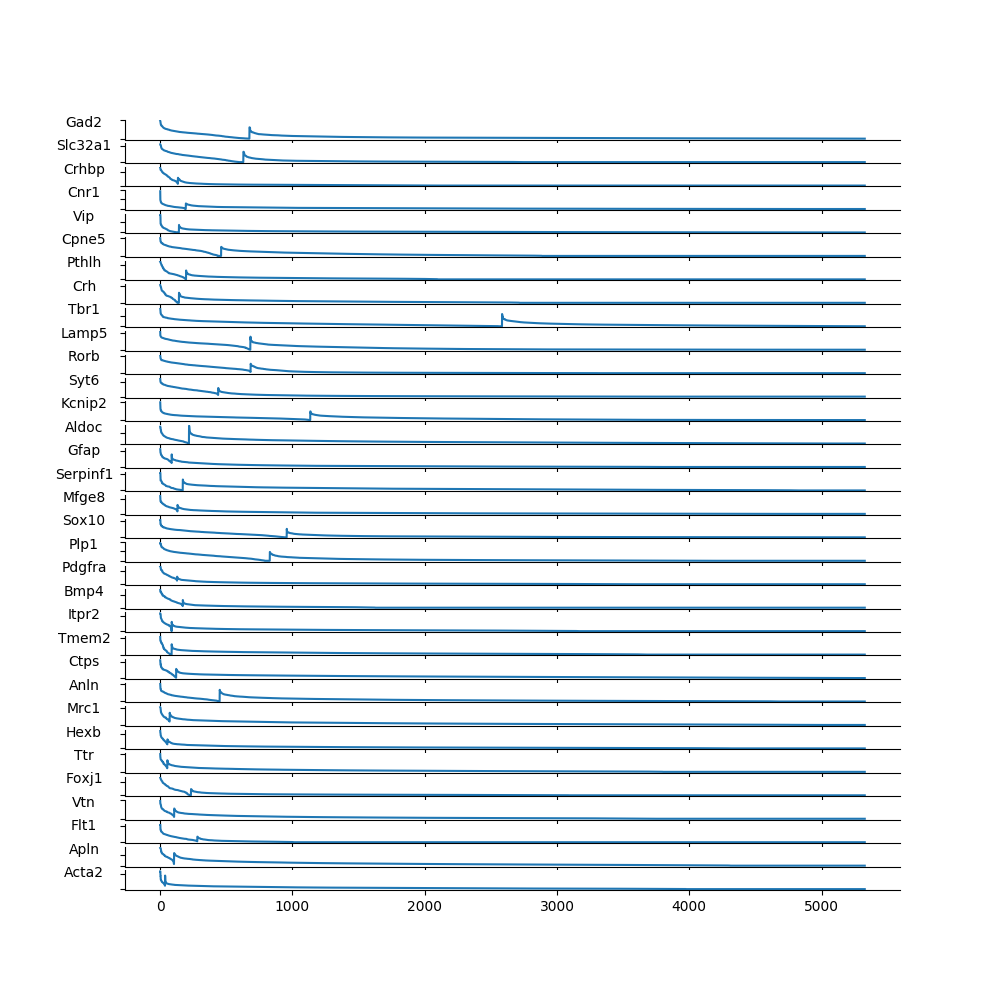

In [19]:
fig, axs = plt.subplots(nrows=df_osmfish.shape[0], figsize=(10,10))

for i, ax in enumerate(axs):
    gene = df_osmfish.index[i]
    
    positive = df_osmfish_totmol.loc[gene, combine_bool_filters(original_labels, positive_clusters[gene])]
    positive = np.sort(positive)[::-1]
    negative = df_osmfish_totmol.loc[gene, combine_bool_filters(original_labels, positive_clusters[gene], mirror=True)]
    negative = np.sort(negative)[::-1]

    data_to_plot = np.append(positive, negative)

    ax.plot(data_to_plot)
    ax.set_ylabel(gene, rotation=0)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yticklabels([])
    ax.tick_params(axis="y",direction="out", pad=22)


<IPython.core.display.Javascript object>


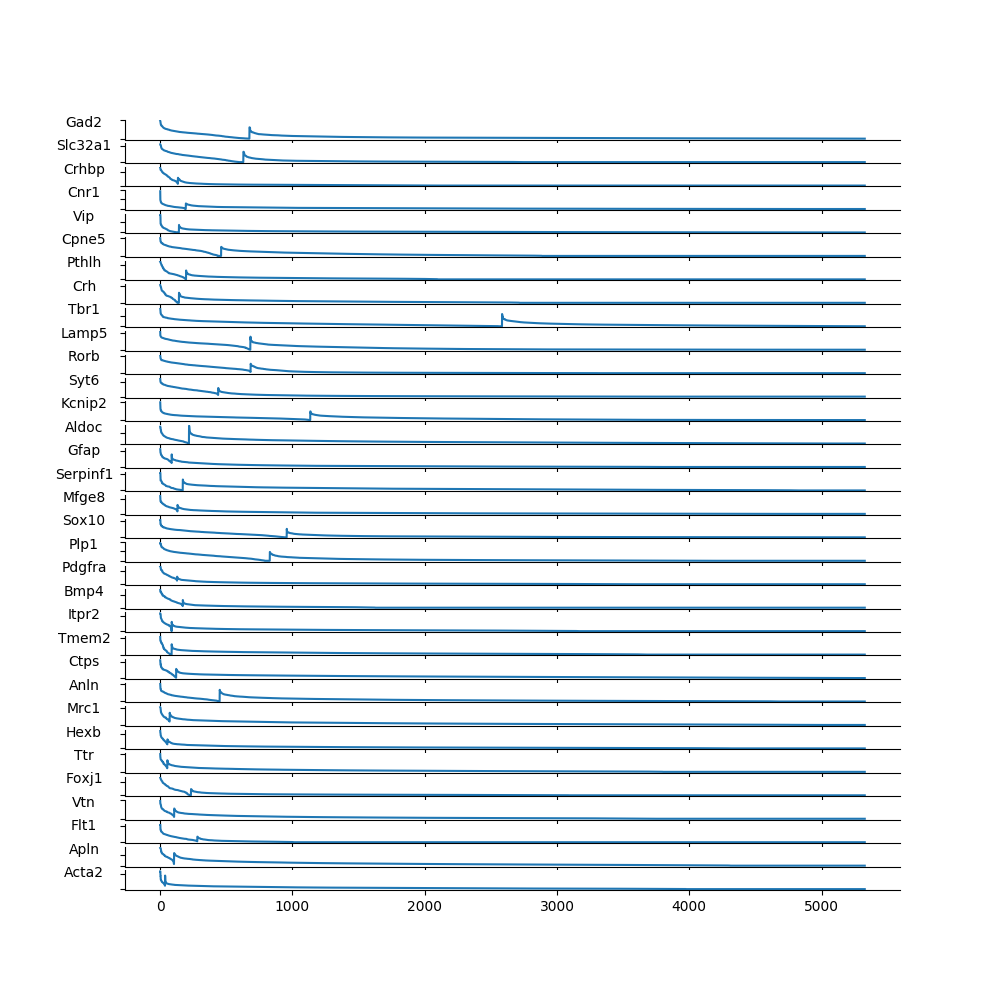

In [20]:
fig, axs = plt.subplots(nrows=df_osmfish.shape[0], figsize=(10,10))

for i, ax in enumerate(axs):
    gene = df_osmfish.index[i]
    
    positive = df_osmfish_totmol.loc[gene, combine_bool_filters(original_labels, positive_clusters[gene])]
    positive = np.sort(positive)[::-1]
    negative = df_osmfish_totmol.loc[gene, combine_bool_filters(original_labels, positive_clusters[gene], mirror=True)]
    negative = np.sort(negative)[::-1]

    data_to_plot = np.append(positive, negative)

    ax.plot(data_to_plot)
    ax.set_ylabel(gene, rotation=0)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yticklabels([])
    ax.tick_params(axis="y",direction="out", pad=22)

<IPython.core.display.Javascript object>


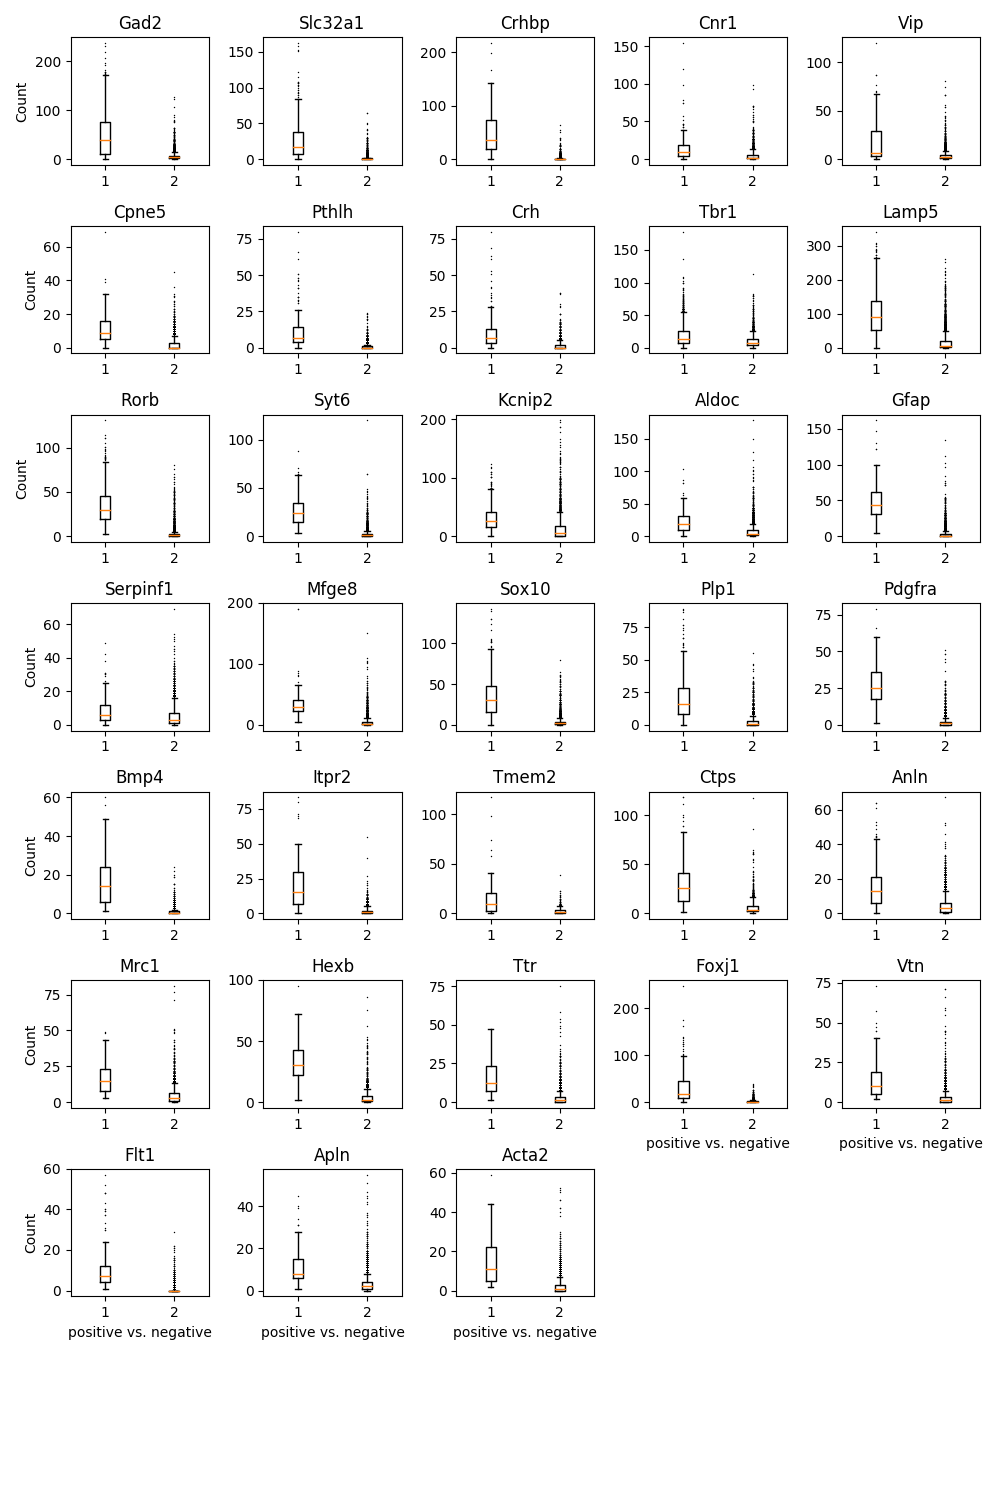

In [21]:
plt.figure(figsize=(10,15))
gs = gridspec.GridSpec(8, 5)

for i in range(len(df_osmfish.index)):
    ax = plt.subplot(gs[i])
    gene = df_osmfish.index[i]
    
    positive = df_osmfish.loc[gene, combine_bool_filters(original_labels, positive_clusters[gene])]
    positive = np.sort(positive)[::-1]
    negative = df_osmfish.loc[gene, combine_bool_filters(original_labels, positive_clusters[gene], mirror=True)]
    negative = np.sort(negative)[::-1]
    
    bp = ax.boxplot([positive, negative], sym='k+')
    ax.set_title(gene)
    
    
    if i in range(len(df_osmfish.index)-5,len(df_osmfish.index)):
        plt.xlabel('positive vs. negative')
    if i%5 ==0:
        plt.ylabel('Count')
    plt.setp(bp['fliers'], markersize=0.5)       
plt.tight_layout()


#plt.savefig('Comparison_positive_negative_clusters.png')

### Distance dependent noise

In [22]:
#Load the cell coordinates into a Pandas Dataframe. Units are pixels
coordinates = np.stack((ds.ca.X, ds.ca.Y))
df_coordinates = pd.DataFrame(data = coordinates, index=['X', 'Y'], columns=ds.ca.CellID)

df_coordinates

,778,1409,3642,1302,1285,769,1466,5870,1392,5682,...,1424,1024,1307,5665,5479,2683,7474,7173,4018,7797
X,18171.230942,19838.080895,11247.433715,19253.231299,19612.527467,18374.295796,18132.019762,4197.789280,20452.072685,3757.866349,...,19253.334268,18633.583887,19082.066333,4311.630337,8079.083690,17435.994894,-2683.548199,-2922.941645,11639.316634,-6223.015850
Y,24590.795275,6456.144687,36626.892415,7389.731237,10793.160566,26286.856654,2115.037027,39465.355903,6184.981169,46281.167166,...,4283.034699,16157.402542,8498.910717,44447.966599,24599.695727,15135.051839,36674.433974,41281.559186,29632.404641,34430.019151


In [23]:
df_coordinates_trim = df_coordinates.copy()

df_coordinates_trim = df_coordinates_trim.loc[:,df_osmfish.columns]

#Convert pixels to metric
pixel_size = 0.065
df_coordinates_trim = df_coordinates_trim * pixel_size
print("Converted pixels to other unit. 1 pixel = {}".format(pixel_size))

#Transposse df_coordinates if the positions are in the rows
if df_coordinates_trim.shape[0] == 2 or df_coordinates_trim.shape[0] == 3:
    df_coordinates_trim = df_coordinates_trim.T
    print('Transposed coordinate dataset')

tree_um = scipy.spatial.KDTree(df_coordinates_trim)

Converted pixels to other unit. 1 pixel = 0.065
Transposed coordinate dataset


In [24]:
distance_to = pd.DataFrame(data=np.zeros([len(np.unique(original_labels)), len(original_labels)]), index=np.unique(original_labels), columns=df_osmfish.columns)

unique_labels = np.unique(original_labels)
n_cells = len(original_labels)
cell_labels = dict(zip(df_osmfish.columns, original_labels))
for cell in df_osmfish.columns:
    c_label = cell_labels[cell]
    #Distance of all cells
    dist = tree_um.query(df_coordinates_trim.loc[cell], k = n_cells)
    #Trim so that it does not find the queried cell
    trim_n = n_cells - len(np.trim_zeros(dist[0], trim='f'))
    #Make list of the labels of the cells sorted by distance
    nearest_labels = [original_labels[i] for i in dist[1][trim_n:]]
    #List of distances sorted
    distances = dist[0][trim_n:]

    #use the closest cells to find the closest neighbour 
    for l in unique_labels:
        distance_to.loc[l, cell] = distances[nearest_labels.index(l)]
        
        #permutations_distance_dict[(c_label, l)].append(distances[nearest_labels.index(l)])

In [25]:
distance_to.head()

,778,1409,3642,1302,1285,769,1466,5870,1392,5682,...,1252,1446,5730,6266,1188,1424,1024,1307,5665,5479
1,13.084587,472.754990,264.092998,499.904233,392.318613,94.838726,207.452720,318.868791,486.440623,252.591574,...,546.995780,361.041929,158.451296,7.664116,326.684047,345.104576,83.527881,543.006128,250.003873,245.033997
2,37.771979,107.949657,94.697620,43.777467,46.017367,57.040113,195.388568,88.552996,111.855409,92.782238,...,68.962629,108.198962,56.445447,58.383581,5.148930,44.383744,107.529771,34.831322,165.449941,177.763265
3,260.609998,154.400417,454.749673,100.362348,104.028659,355.684313,96.505689,463.844031,197.987855,33.138391,...,182.312721,146.786697,117.336564,251.526498,36.589320,233.024686,96.156286,109.260764,141.928721,242.194628
4,36.072530,1189.486577,12.385141,1127.095795,907.216936,26.511890,1469.880310,9.576866,1210.157969,240.821006,...,1063.962495,1257.510180,150.997456,244.654960,816.680167,1328.947389,556.667811,1054.723555,168.672125,473.069659
5,359.492821,1533.174720,44.472607,1471.860120,1250.978707,248.744710,1815.915415,50.226775,1552.450673,238.238267,...,1406.020101,1603.375850,174.370523,179.395902,1163.168080,1673.793701,902.580308,1399.756917,130.982134,578.015974


In [26]:
label_cells = {}
for l in np.unique(original_labels):
    label_cells[l] = []
for i, label in enumerate(original_labels):
    label_cells[label].append(df_osmfish.columns[i])

In [135]:
from scipy.stats import mannwhitneyu

<IPython.core.display.Javascript object>


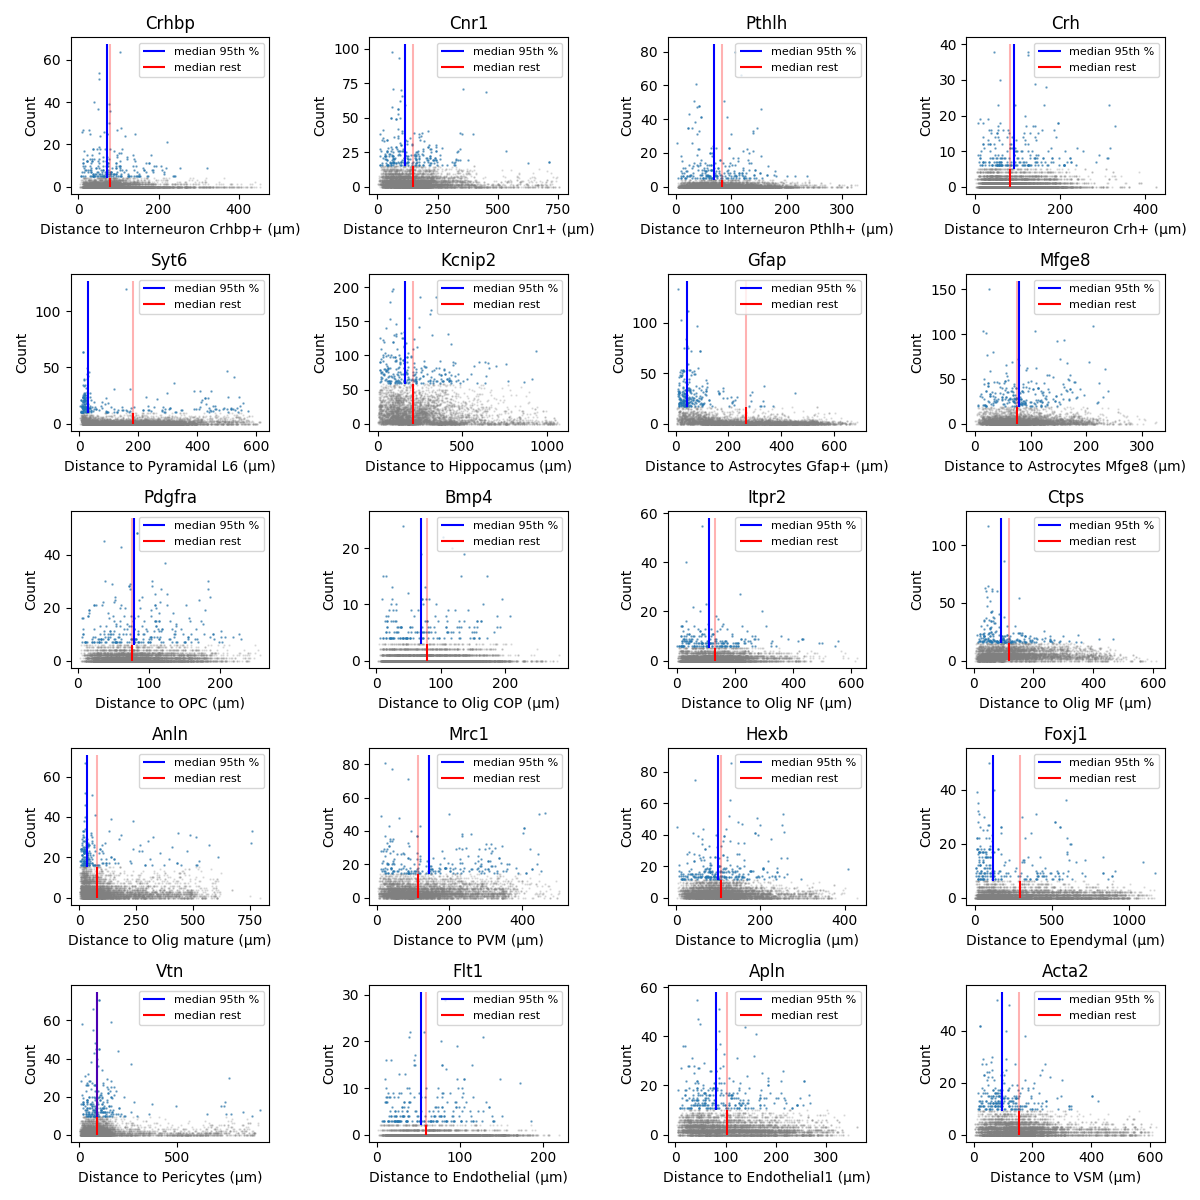

In [137]:
#get cells not of type

to_plot = [
    ['Microglia', 'Hexb', 29],
    ['Ependymal', 'Foxj1', 27],
    ['OPC', 'Pdgfra', 32],
    ['Endothelial', 'Flt1', 7],
    ['Astrocytes Gfap+', 'Gfap', 3],
    ['Astrocytes Mfge8', 'Mfge8', 2],
    ['Interneuron Crhbp+', 'Crhbp', 17],
    ['PVM', 'Mrc1', 28]
]

to_plot2 = [
    ['Interneuron Crhbp+', 'Crhbp', 17],
    ['Interneuron Cnr1+', 'Cnr1', 14],
    ['Interneuron Pthlh+', 'Pthlh', 16],
    ['Interneuron Crh+', 'Crh', 20],
    ['Pyramidal L6', 'Syt6', 1],
    ['Hippocamus', 'Kcnip2', 13],
    ['Astrocytes Gfap+', 'Gfap', 3],
    ['Astrocytes Mfge8', 'Mfge8', 2],
    ['OPC', 'Pdgfra', 32],
    ['Olig COP', 'Bmp4', 33],
    ['Olig NF', 'Itpr2', 30],
    ['Olig MF', 'Ctps', 22],
    ['Olig mature', 'Anln', 21],
    ['PVM', 'Mrc1', 28],
    ['Microglia', 'Hexb', 29],
    ['Ependymal', 'Foxj1', 27],
    ['Pericytes', 'Vtn', 31],
    ['Endothelial', 'Flt1', 7],
    ['Endothelial1', 'Apln', 26],
    ['VSM', 'Acta2', 25],
]

plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(5, 4)

for i, data in enumerate(to_plot2):
    ax = plt.subplot(gs[i])
    
    celltype, gene, label_of_interest = data
    
    mask = original_labels != label_of_interest
    ax.scatter(distance_to.loc[label_of_interest, mask], df_osmfish.loc[gene, mask], s=0.5, alpha=0.2, c='gray')
    
    
    
    percentile = np.percentile(df_osmfish.loc[gene, mask], 95)
    
    mask2 = df_osmfish.loc[gene, :] > percentile
    mask3 = np.logical_and(mask, mask2)
    ax.scatter(distance_to.loc[label_of_interest, mask3], df_osmfish.loc[gene, mask3], s=0.5, alpha=0.5)
    median_percen = np.median(distance_to.loc[label_of_interest, mask3])
    top_plot = ax.get_ylim()[1]
    median_percen_line = ax.vlines(median_percen, percentile, top_plot, color='blue', label='median 95th %')
    #ax.text(median_percen, 0.9 * ax.get_ylim()[1], 'median', fontsize=6)
    
    mask4 = mask3 != True
    
    median_rest = ax.vlines(np.median(distance_to.loc[label_of_interest, mask4]),0, percentile, color='red', label='median rest')
    ax.vlines(np.median(distance_to.loc[label_of_interest, mask4]), percentile, top_plot, color='red', alpha=0.3)   
    
    #legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
    legend = plt.legend(handles=[median_percen_line, median_rest], loc='upper right', fontsize=8)

    ax.set_ylabel('Count')
    ax.set_xlabel('Distance to {} (\u00B5m)'.format(celltype))
    ax.set_title(gene)
    
plt.tight_layout()

plt.savefig('distance_dependent_contamination.png', dpi=300)

### transcript clusterdness

In [29]:
import h5py
from astropy.stats import RipleysKEstimator
filename = '/home/lars/storage/Documents/Cortex_FISH/mRNA_coords_raw_counting.hdf5'
dot_coordinates = h5py.File(filename, 'r')

In [45]:
genes_transcripts = ['Acta2_Hybridization5',
 'Aldoc_Hybridization1',
 'Anln_Hybridization9',
 'Apln_Hybridization10',
 'Bmp4_Hybridization6',
 'Cnr1_Hybridization13',
 'Cpne5_Hybridization5',
 'Crh_Hybridization10',
 'Crhbp_Hybridization10',
 'Ctps_Hybridization7',
 'Flt1_Hybridization2',
 'Foxj1_Hybridization1',
 'Gad2_Hybridization2',
 'Gfap_Hybridization2',
 'Hexb_Hybridization3',
 'Itpr2_Hybridization6',
 'Kcnip_Hybridization12',
 'Lamp5_Hybridization9',
 'Mfge8_Hybridization3',
 'Mrc1_Hybridization3',
 'Pdgfra_Hybridization8',
 'Plp1_Hybridization13',
 'Pthlh_Hybridization8',
 'Rorb_Hybridization7',
 'Serpinf1_Hybridization8',
 'Slc32a1_Hybridization12',
 'Sox10_Hybridization7',
 'Syt6_Hybridization11',
 'Tbr1_Hybridization1',
 'Tmem6_Hybridization11',
 'Ttr_Hybridization13',
 'Vip_Hybridization6',
 'Vtn_Hybridization12',]

In [30]:
data = np.array(dot_coordinates['Syt6_Hybridization11'])
data[:,0]>2500


array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
1<a[:,1]>3

<IPython.core.display.Javascript object>


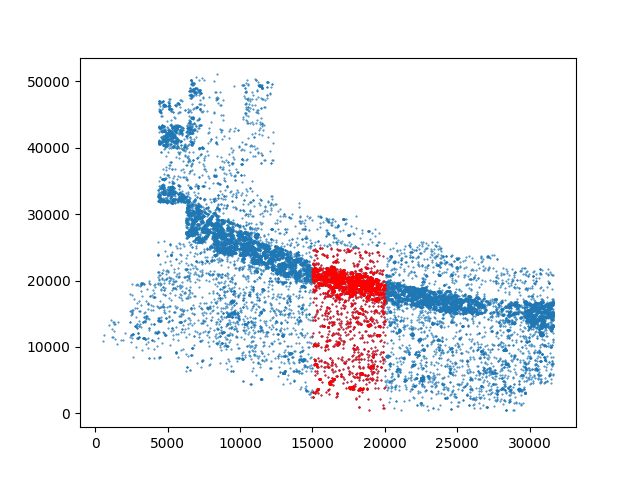

In [33]:
x_selection = np.logical_and(data[:,0]<20000, data[:,0]>15000)
y_selection = np.logical_and(data[:,1]<25000, data[:,1]>0)


data2 = data[np.where(np.logical_and(x_selection, y_selection))]

plt.figure()

plt.scatter(data[:,0], data[:,1], s=0.2)
plt.scatter(data2[:,0], data2[:,1], s=0.2, c='red')

<IPython.core.display.Javascript object>


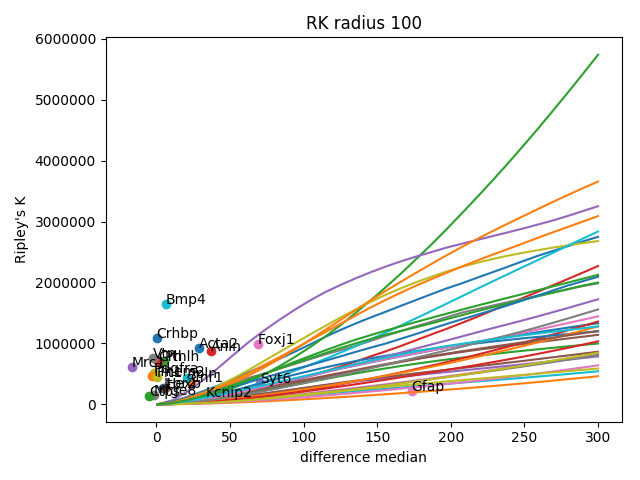

Acta2_Hybridization5 (1381, 2)
Aldoc_Hybridization1 (33520, 2)
Anln_Hybridization9 (4645, 2)
Apln_Hybridization10 (2589, 2)
Bmp4_Hybridization6 (1770, 2)
Cnr1_Hybridization13 (4237, 2)
Cpne5_Hybridization5 (4692, 2)
Crh_Hybridization10 (1145, 2)
Crhbp_Hybridization10 (2917, 2)
Ctps_Hybridization7 (7365, 2)
Flt1_Hybridization2 (4336, 2)
Foxj1_Hybridization1 (2415, 2)
Gad2_Hybridization2 (12223, 2)
Gfap_Hybridization2 (15611, 2)
Hexb_Hybridization3 (9257, 2)
Itpr2_Hybridization6 (3511, 2)
Kcnip_Hybridization12 (22354, 2)
Lamp5_Hybridization9 (47635, 2)
Mfge8_Hybridization3 (20927, 2)
Mrc1_Hybridization3 (3477, 2)
Pdgfra_Hybridization8 (5062, 2)
Plp1_Hybridization13 (7557, 2)
Pthlh_Hybridization8 (1474, 2)
Rorb_Hybridization7 (6488, 2)
Serpinf1_Hybridization8 (2738, 2)
Slc32a1_Hybridization12 (2472, 2)
Sox10_Hybridization7 (7763, 2)
Syt6_Hybridization11 (4571, 2)
Tbr1_Hybridization1 (23085, 2)
Tmem6_Hybridization11 (2639, 2)
Ttr_Hybridization13 (1146, 2)
Vip_Hybridization6 (2507, 2)
Vtn_H

In [105]:
#Select clusters that are considered to have a spatial distribution in confined areas.
#Calculate Ripley's K estimate for the distribution of all clusters. 

plt.figure()
RK_est = {}

for i in list(genes_transcripts):
    
    time.sleep(3)
    data = np.array(dot_coordinates[i])
    x_selection = np.logical_and(data[:,0]<20000, data[:,0]>15000)
    y_selection = np.logical_and(data[:,1]<25000, data[:,1]>0)


    data2 = data[np.where(np.logical_and(x_selection, y_selection))]
    print(i, data2.shape)
    
    x_min = data2[:,0].min()
    x_max = data2[:,0].max()
    y_min = data2[:,1].min()
    y_max = data2[:,1].max()
    area = ((x_max-x_min)*(y_max-y_min))
    Kest = RipleysKEstimator(area, x_max, y_max, x_min, y_min)
    radii = np.linspace(1,300, 30)

    estimate = Kest(data=data2, radii=radii, mode='none')
    RK_est[i] = estimate
    
    plt.plot(radii, estimate)

plt.ylabel("Ripley's K")
plt.xlabel('distance (pix)')
plt.title("Ripley's K transcript localization")

plt.savefig('Ripley_K_radii.png', dpi=300)

In [84]:

RK_10 = {}


for i in list(genes_transcripts):
    
    data = np.array(dot_coordinates[i])
    x_selection = np.logical_and(data[:,0]<20000, data[:,0]>15000)
    y_selection = np.logical_and(data[:,1]<25000, data[:,1]>0)


    data2 = data[np.where(np.logical_and(x_selection, y_selection))]
    print(i, data2.shape)
    
    x_min = data2[:,0].min()
    x_max = data2[:,0].max()
    y_min = data2[:,1].min()
    y_max = data2[:,1].max()
    area = ((x_max-x_min)*(y_max-y_min))
    Kest = RipleysKEstimator(area, x_max, y_max, x_min, y_min)
    radii = np.array([10])

    estimate = Kest(data=data2, radii=radii, mode='none')
    
    RK_10[i] = estimate
   



Acta2_Hybridization5 (1381, 2)
Aldoc_Hybridization1 (33520, 2)
Anln_Hybridization9 (4645, 2)
Apln_Hybridization10 (2589, 2)
Bmp4_Hybridization6 (1770, 2)
Cnr1_Hybridization13 (4237, 2)
Cpne5_Hybridization5 (4692, 2)
Crh_Hybridization10 (1145, 2)
Crhbp_Hybridization10 (2917, 2)
Ctps_Hybridization7 (7365, 2)
Flt1_Hybridization2 (4336, 2)
Foxj1_Hybridization1 (2415, 2)
Gad2_Hybridization2 (12223, 2)
Gfap_Hybridization2 (15611, 2)
Hexb_Hybridization3 (9257, 2)
Itpr2_Hybridization6 (3511, 2)
Kcnip_Hybridization12 (22354, 2)
Lamp5_Hybridization9 (47635, 2)
Mfge8_Hybridization3 (20927, 2)
Mrc1_Hybridization3 (3477, 2)
Pdgfra_Hybridization8 (5062, 2)
Plp1_Hybridization13 (7557, 2)
Pthlh_Hybridization8 (1474, 2)
Rorb_Hybridization7 (6488, 2)
Serpinf1_Hybridization8 (2738, 2)
Slc32a1_Hybridization12 (2472, 2)
Sox10_Hybridization7 (7763, 2)
Syt6_Hybridization11 (4571, 2)
Tbr1_Hybridization1 (23085, 2)
Tmem6_Hybridization11 (2639, 2)
Ttr_Hybridization13 (1146, 2)
Vip_Hybridization6 (2507, 2)
Vtn_H

In [88]:
d = """Acta2_Hybridization5 (1381, 2)
Aldoc_Hybridization1 (33520, 2)
Anln_Hybridization9 (4645, 2)
Apln_Hybridization10 (2589, 2)
Bmp4_Hybridization6 (1770, 2)
Cnr1_Hybridization13 (4237, 2)
Cpne5_Hybridization5 (4692, 2)
Crh_Hybridization10 (1145, 2)
Crhbp_Hybridization10 (2917, 2)
Ctps_Hybridization7 (7365, 2)
Flt1_Hybridization2 (4336, 2)
Foxj1_Hybridization1 (2415, 2)
Gad2_Hybridization2 (12223, 2)
Gfap_Hybridization2 (15611, 2)
Hexb_Hybridization3 (9257, 2)
Itpr2_Hybridization6 (3511, 2)
Kcnip_Hybridization12 (22354, 2)
Klk6_Hybridization5 (304, 2)
Lamp5_Hybridization9 (47635, 2)
Lum_Hybridization9 (1180, 2)
Mfge8_Hybridization3 (20927, 2)
Mrc1_Hybridization3 (3477, 2)
Pdgfra_Hybridization8 (5062, 2)
Plp1_Hybridization13 (7557, 2)
Pthlh_Hybridization8 (1474, 2)
Rorb_Hybridization7 (6488, 2)
Serpinf1_Hybridization8 (2738, 2)
Slc32a1_Hybridization12 (2472, 2)
Sox10_Hybridization7 (7763, 2)
Syt6_Hybridization11 (4571, 2)
Tbr1_Hybridization1 (23085, 2)
Tmem6_Hybridization11 (2639, 2)
Ttr_Hybridization13 (1146, 2)
Vip_Hybridization6 (2507, 2)
Vtn_Hybridization12 (2739, 2)"""

In [101]:
molecules_measured = {}
for i in d.split('\n'):
    molecules_measured[i.split()[0]] = int(i.split()[1].split(',')[0][1:])

molecules_measured
    

{'Acta2_Hybridization5': 1381,
 'Aldoc_Hybridization1': 33520,
 'Anln_Hybridization9': 4645,
 'Apln_Hybridization10': 2589,
 'Bmp4_Hybridization6': 1770,
 'Cnr1_Hybridization13': 4237,
 'Cpne5_Hybridization5': 4692,
 'Crh_Hybridization10': 1145,
 'Crhbp_Hybridization10': 2917,
 'Ctps_Hybridization7': 7365,
 'Flt1_Hybridization2': 4336,
 'Foxj1_Hybridization1': 2415,
 'Gad2_Hybridization2': 12223,
 'Gfap_Hybridization2': 15611,
 'Hexb_Hybridization3': 9257,
 'Itpr2_Hybridization6': 3511,
 'Kcnip_Hybridization12': 22354,
 'Klk6_Hybridization5': 304,
 'Lamp5_Hybridization9': 47635,
 'Lum_Hybridization9': 1180,
 'Mfge8_Hybridization3': 20927,
 'Mrc1_Hybridization3': 3477,
 'Pdgfra_Hybridization8': 5062,
 'Plp1_Hybridization13': 7557,
 'Pthlh_Hybridization8': 1474,
 'Rorb_Hybridization7': 6488,
 'Serpinf1_Hybridization8': 2738,
 'Slc32a1_Hybridization12': 2472,
 'Sox10_Hybridization7': 7763,
 'Syt6_Hybridization11': 4571,
 'Tbr1_Hybridization1': 23085,
 'Tmem6_Hybridization11': 2639,
 'Ttr_

In [ ]:
RK_10_corr = 

<IPython.core.display.Javascript object>


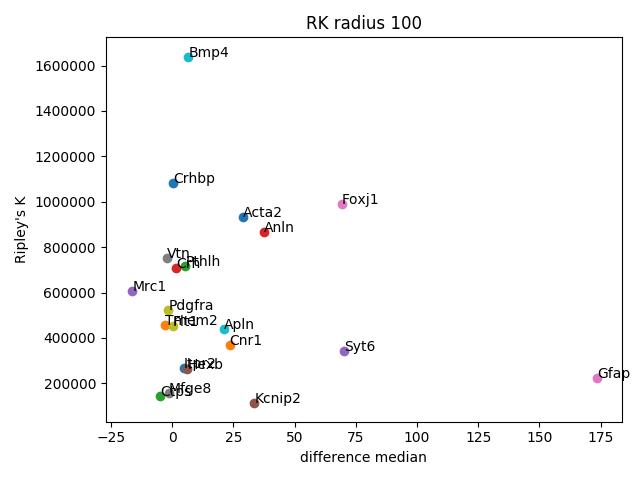

In [122]:


to_plot = [
    ['Interneuron Crhbp+', 'Crhbp', 17],
    ['Interneuron Cnr1+', 'Cnr1', 14],
    ['Interneuron Pthlh+', 'Pthlh', 16],
    ['Interneuron Crh+', 'Crh', 20],
    ['Pyramidal L6', 'Syt6', 1],
    ['Hippocamus', 'Kcnip2', 13],
    ['Astrocytes Gfap+', 'Gfap', 3],
    ['Astrocytes Mfge8', 'Mfge8', 2],
    ['OPC', 'Pdgfra', 32],
    ['Olig COP', 'Bmp4', 33],
    ['Olig NF', 'Itpr2', 30],
    ['Olig NF', 'Tmem2', 30],
    ['Olig MF', 'Ctps', 22],
    ['Olig mature', 'Anln', 21],
    ['PVM', 'Mrc1', 28],
    ['Microglia', 'Hexb', 29],
    ['Ependymal', 'Foxj1', 27],
    ['Pericytes', 'Vtn', 31],
    ['Endothelial', 'Flt1', 7],
    ['Endothelial1', 'Apln', 26],
    ['VSM', 'Acta2', 25],
]

plt.figure()

differences_median = []
RK_plotted = []

for data in to_plot:
    #gene=g.split('_')[0]
    #if gene == 'Kcnip':
    #    gene='Kcnip2'
    #if gene == 'Tmem6':
    #    gene='Tmem2'

    celltype, gene, label_of_interest = data

    mask = original_labels != label_of_interest
    median_all = np.median(distance_to.loc[label_of_interest, mask])

    percentile = np.percentile(df_osmfish.loc[gene, mask], 80)
    mask2 = df_osmfish.loc[gene, :] > percentile
    mask3 = np.logical_and(mask, mask2)
    median_percen = np.median(distance_to.loc[label_of_interest, mask3])

    diff_median =  median_all - median_percen

    full_gene = [i for i in genes_transcripts if i.startswith(gene[:-1])][0]

    RK = RK_100[full_gene]
    #RK = RK_est[full_gene][i]

    #RK = RK / molecules_measured[full_gene]
    
    differences_median.append(diff_median)
    RK_plotted.append(RK[0])


    plt.scatter(diff_median, RK, label = gene)
    plt.text(diff_median, RK, gene)
    


plt.title('RK radius 100') 
plt.ylabel("Ripley's K")
plt.xlabel('difference median')


plt.tight_layout()
 
#print(np.correlate(differences_median, RK_plotted))    
    
#plt.savefig('RK_leakage_radius_10.png', dpi=300)

In [123]:
np.corrcoef(differences_median, RK_plotted)

array([[ 1.        , -0.13631382],
       [-0.13631382,  1.        ]])

In [ ]:
to_plot = [
    ['Microglia', 'Hexb', 29],
    ['Ependymal', 'Foxj1', 27],
    ['OPC', 'Pdgfra', 32],
    ['Endothelial', 'Flt1', 7],
    ['Astrocytes Gfap+', 'Gfap', 3],
    ['Astrocytes Mfge8', 'Mfge8', 2],
    ['Interneuron Crhbp+', 'Crhbp', 17],
    ['PVM', 'Mrc1', 28]
]

plt.figure(figsize=(12,5))
gs = gridspec.GridSpec(2, 4)

for i, data in enumerate(to_plot):
    ax = plt.subplot(gs[i])
    
    celltype, gene, label_of_interest = data
    
    mask = original_labels != label_of_interest
    ax.scatter(distance_to.loc[label_of_interest, mask], df_osmfish.loc[gene, mask], s=0.5, alpha=0.2, c='gray')
    
    
    
    percentile = np.percentile(df_osmfish.loc[gene, mask], 95)
    
    mask2 = df_osmfish.loc[gene, :] > percentile
    mask3 = np.logical_and(mask, mask2)
    ax.scatter(distance_to.loc[label_of_interest, mask3], df_osmfish.loc[gene, mask3], s=0.5, alpha=0.5)
    median_percen = np.median(distance_to.loc[label_of_interest, mask3])
    top_plot = ax.get_ylim()[1]
    median_percen_line = ax.vlines(median_percen, percentile, top_plot, color='blue', label='median 95th %')
    #ax.text(median_percen, 0.9 * ax.get_ylim()[1], 'median', fontsize=6)
    
    median_all = ax.vlines(np.median(distance_to.loc[label_of_interest, mask]),0, percentile, color='red', label='median all')
    ax.vlines(np.median(distance_to.loc[label_of_interest, mask]), percentile, top_plot, color='red', alpha=0.3)
    
    #legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
    legend = plt.legend(handles=[median_percen_line, median_all], loc='upper right', fontsize=8)

    ax.set_ylabel('Count')
    ax.set_xlabel('Distance to {} (\u00B5m)'.format(celltype))
    ax.set_title(gene)
    
plt.tight_layout()

# Test code

In [ ]:
#draw from binomial with parameters
fraction = 0.0001
gene = 'Lamp5'
np.sum(nbinom_rvs(df_osmfish.shape[1], fit[gene][0], fit[gene][1] * fraction))

In [ ]:
df_osmfish.head()

In [ ]:
#Make new dataset and add noise
copy = df_osmfish.copy()
fraction = 0.5

for gene in copy.index:
    noise = nbinom_rvs(df_osmfish.shape[1], fit[gene][0], fit[gene][1] * fraction)
    copy.loc[gene] += noise

copy.head()

In [ ]:
#normalize
copy_n = normalization(copy)
copy_n.head()

In [ ]:
df_osmfish_totmol.head()

In [ ]:
add1 = df_osmfish.copy()
add1.loc['Bmp4', '778'] += 1

add1 = normalization(add1)

add1.head()



In [ ]:
#cluster
new_labels = clustering(add1)

In [ ]:
#evaluate
cluster_compare(original_labels, new_labels)

In [ ]:
from sklearn.metrics import homogeneity_completeness_v_measure as hcv

hcv(original_labels, new_labels)

In [ ]:
heat_map(df_osmfish_totmol, new_labels)

In [ ]:
fraction = 0.5, similarity = 0.9586219754590131

In [ ]:
fitdist(x)

In [ ]:
def nbinom_rvs(nsamples, size, mu):
    rnbinom = robj.r('rnbinom')
    return np.array( rnbinom(n=nsamples,size=size,mu=mu) )

In [ ]:
nbinom_rvs_fromfit(10000, fitdist(y)).mean()

In [ ]:
linsp = np.arange(0,40)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fitdist(y)

In [ ]:
plt.figure()
plt.scatter(linsp, nbinom_pdf_fromfit(linsp, fitdist(y)))

In [ ]:
plt.scatter(linsp,  6.05798501, 8.85053236]

In [ ]:
plt.figure()
plt.scatter(linsp,  nbinom_pdf(linsp,6.05798501, 8.85053236))
plt.scatter(linsp,  nbinom_pdf(linsp,6.05798501, 8.85053236/4.))

In [ ]:
plt.hist(nbinom_rvs(1000,6.05798501, 8.85053236))
plt.hist(nbinom_rvs(1000,6.05798501, 8.85053236/2.))

In [ ]:
3, 0.8